In [546]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from category_encoders import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas_profiling as pp
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix
!pip install shap

In [514]:
!pip install pandas_profiling

In [573]:
def wrangle(X):
    X = X.copy()


    #add target features, this will be a classification model
    X['substantiated'] = X['board_disposition'].str.contains('Substantiated')
    X = X.drop(columns='board_disposition')
    
    #add new feature (multiple complaints)
    #X['multiple_complaints'] = X.duplicated(subset='unique_mos_id', keep=False) & X.duplicated(subset='complaint_id', keep=False) 
    # X['lots of allegations'] = X['unique_mos_id'].value_counts() >= 10      
    # X = X.drop(columns='unique_mos_id', 'complaint_id')


    #add new feature (length of review in months)
    X['review_length_mo'] = ((X['year_closed'] *12) + X['month_closed']) - ((X['year_received']*12) + X['month_received'])

    #drop rows with zero in sheild_no
    X = X.loc[(X['shield_no']!=0)]

    #drop unneded cols
    #maybe i dont need these idk but im keeping rn,    'rank_incident', 'complainant_ethnicity', 'complainant_gender' , 'mos_ethnicity' 
    unneded_col = ['first_name', 'last_name', 'rank_abbrev_incident','rank_now', 'command_now', 'rank_abbrev_now', 'unique_mos_id',  'shield_no', 'command_at_incident', 'year_closed', 'month_closed', 'month_received', 'fado_type', 'mos_ethnicity', 'complaint_id'   ]
    X = X.drop(columns=unneded_col)

    #change index to year recieved
    X = X.set_index('year_received')
    X = X.sort_index()

    #drop duplicated rows
    X.drop_duplicates(keep='first', inplace=True)

    X.dropna(inplace=True, how='any')
    return X

In [615]:
df = pd.read_csv('allegations.csv')

In [575]:
df.head()
df.shape

(33358, 27)

In [576]:
#set up new dataframe to make feature
lots_of_allegations = df['unique_mos_id'].value_counts(dropna=False).rename_axis('unique_mos_id').reset_index(name='counts')

In [577]:
#officers with more than 10 ccrb reports
lots_of_allegations['lots_of_allegations'] = (lots_of_allegations['counts'] >=10)

In [578]:
lots_of_allegations = lots_of_allegations.drop(columns='counts')

In [579]:
lots_of_allegations.head()

,unique_mos_id,lots_of_allegations
0,25861,True
1,18731,True
2,19489,True
3,18530,True
4,18589,True


In [580]:
#merge lots of allegations based on the unique member of sevice ID
df = df.merge(lots_of_allegations, on='unique_mos_id')

In [581]:
df = wrangle(df)

In [582]:
df.head()

,rank_incident,mos_gender,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,allegation,precinct,contact_reason,outcome_description,lots_of_allegations,substantiated,review_length_mo
year_received,,,,,,,,,,,,,
1998,Police Officer,M,32,Black,Male,32.0,Frisk and/or search,40.0,C/V intervened on behalf of/observed encounter...,Arrest - OGA,False,False,19
1998,Police Officer,M,32,Black,Male,32.0,Physical force,40.0,C/V intervened on behalf of/observed encounter...,Arrest - OGA,False,False,19
1999,Police Officer,M,33,Hispanic,Male,16.0,Physical force,46.0,PD suspected C/V of violation/crime - street,Arrest - resisting arrest,True,False,16
1999,Police Officer,M,24,Black,Male,18.0,Physical force,67.0,Parking violation,Arrest - disorderly conduct,False,False,17
1999,Detective,M,26,Black,Male,33.0,Vehicle,1.0,Other,No arrest made or summons issued,False,True,7


In [583]:
df.profile_report()

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


In [584]:
#make sure nothing in this feature looks weird

df['review_length_mo'].value_counts()

6      2010
5      1827
7      1776
10     1723
9      1721
8      1643
11     1633
12     1603
13     1538
14     1451
4      1438
15     1260
16     1189
17      828
3       638
18      572
19      211
2       107
20       63
21       56
23       27
22       22
25       19
1        17
24       14
34       13
27       12
69        6
26        5
35        5
75        4
29        4
33        3
40        3
31        2
28        2
45        1
110       1
55        1
51        1
66        1
41        1
37        1
47        1
Name: review_length_mo, dtype: int64

In [585]:
#split target matrix from dataframe

target = 'substantiated'
y = df[target]
X = df.drop(columns=target)

In [586]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=42)

In [587]:
X_train.head()

,rank_incident,mos_gender,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,allegation,precinct,contact_reason,outcome_description,lots_of_allegations,review_length_mo
year_received,,,,,,,,,,,,
2018,Police Officer,M,27,Black,Male,28.0,Electronic device information deletion,75.0,Other violation of VTL,Arrest - other violation/crime,True,17
2014,Sergeant,M,43,Hispanic,Male,24.0,Stop,121.0,Other,No arrest made or summons issued,True,15
2011,Police Officer,M,31,Black,Male,40.0,Vehicle stop,48.0,PD suspected C/V of violation/crime - auto,Arrest - other violation/crime,True,12
2001,Police Officer,M,27,Black,Male,29.0,Physical force,30.0,PD suspected C/V of violation/crime - street,Arrest - other violation/crime,False,18
2008,Police Officer,M,35,Other Race,Male,52.0,Physical force,13.0,Moving violation,Moving violation summons issued,False,7


In [588]:
# # determine categorical and numerical features for training set
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object', 'bool']).columns

# # determine categorical and numerical features for test set
numerical_features_test = X_test.select_dtypes(include=['int64', 'float64']).columns
categorical_features_test = X_test.select_dtypes(include=['object', 'bool']).columns


#pipeline for transforming categorical data columns
#stategy 'most_frequent' used to impute the categorical data
cat_pipe = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OrdinalEncoder(),
 
)
num_pipe = make_pipeline(
    SimpleImputer(),
   
)
#column transformer for training data set
ct = ColumnTransformer(
    [('cat_pipe', cat_pipe, categorical_features),
     ('num_pipe', num_pipe, numerical_features)]
)
#transformer for test dataset 
ct_test = ColumnTransformer(
    [('cat_pipe', cat_pipe, categorical_features_test),
     ('num_pipe', num_pipe, numerical_features_test)]
)

In [589]:
#baseline for model. Majority class (unsubstantiated(0))
print('baseline:',y_train.value_counts(normalize=True).max())

baseline: 0.7436840422129837


In [590]:
#transform columns in training and test sets

XT_train = ct.fit_transform(X_train)
XT_test = ct_test.fit_transform(X_test)

In [591]:
#linear model
lr_model = LogisticRegression(random_state=42)
lr_model.fit(XT_train, y_train)

LogisticRegression(random_state=42)

In [592]:
print('logistic model acuracy score:', lr_model.score(XT_test, y_test))

logistic model acuracy score: 0.7484544873161373


In [593]:
#basic untuned random forest model fitting the trandformed training data. 
model_rf = RandomForestClassifier(
                                n_jobs=-1,
                                random_state=42)

model_rf.fit(XT_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [594]:
print('model rf training score:',model_rf.score(XT_train, y_train))
print('model rf validation score:',model_rf.score(XT_test, y_test))

model rf training score: 0.993657392602068
model rf validation score: 0.7360903858452356


<AxesSubplot:>

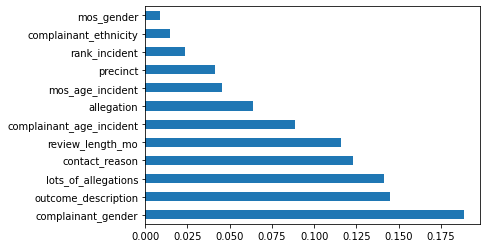

In [614]:
feat_importances = pd.Series(model_rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')

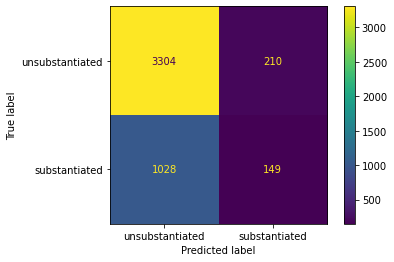

In [617]:
#confusion matrix of untuned model

plot_confusion_matrix(model_rf,
                      XT_test, #use validation data for confusion matrix
                      y_test,
                      values_format='.0f',
                      display_labels=['unsubstantiated', 'substantiated']);

In [537]:
#hyperparameter tuning for random forest model using grid search
params = {
    'max_depth': range(1,36,2),
    'n_estimators':range(55,75,5),
    'min_impurity_decrease': range(0,5,1),
    'max_features': range(0,10,1),
    'min_samples_leaf': range(0,5,1)
    
}
model = GridSearchCV(model_rf,
                           param_grid=params,
                           scoring='accuracy',
                           cv=5,
                           n_jobs=-1,
                           verbose=1)

In [442]:
model.fit(XT_train, y_train)

Fitting 5 folds for each of 18000 candidates, totalling 90000 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 674 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 1474 tasks      | elapsed:   56.5s
[Parallel(n_jobs=-1)]: Done 2024 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2674 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 3424 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 4274 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 5224 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 6274 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 7424 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 8674 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 10024 tasks  

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 36, 2),
                         'max_features': range(0, 10),
                         'min_impurity_decrease': range(0, 5),
                         'min_samples_leaf': range(0, 5),
                         'n_estimators': range(55, 75, 5)},
             scoring='accuracy', verbose=1)

In [538]:
#parameters for my tuned model
model.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [597]:
#new tuned random forest model
tuned_model_rf = RandomForestClassifier(n_estimators=70,
                                max_samples=.02,
                                max_features=4,
                                max_depth=25,
                                min_impurity_decrease=0,
                                n_jobs=-1,
                                min_samples_leaf=1,
                                random_state=42)

In [598]:
#reinitialize the test and training data
XT_train = ct.fit_transform(X_train)
XT_test = ct_test.fit_transform(X_test)

In [599]:
#refit model
tuned_model_rf.fit(XT_train, y_train)

RandomForestClassifier(max_depth=25, max_features=4, max_samples=0.02,
                       min_impurity_decrease=0, n_estimators=70, n_jobs=-1,
                       random_state=42)

In [600]:
print('tuned rf model training score',tuned_model_rf.score(XT_train, y_train))
print('tuned rf model val score:', tuned_model_rf.score(XT_test, y_test))

tuned rf model training score 0.7533845005862915
tuned rf model val score: 0.7441910040503091


<AxesSubplot:>

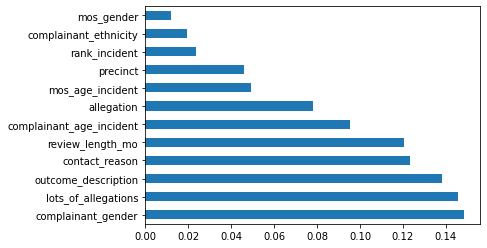

In [613]:

#plot feature importances to the tuned model
feat_importances_tuned = pd.Series(tuned_model_rf.feature_importances_, index=X_train.columns)
feat_importances_tuned.nlargest(20).plot(kind='barh')

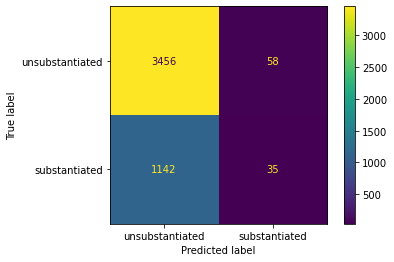

In [602]:
#confusion matrix for tuned randomed forest

plot_confusion_matrix(tuned_model_rf,
                      XT_test, #use validation data for confusion matrix
                      y_test,
                      values_format='.0f',
                      display_labels=['unsubstantiated', 'substantiated']);

In [603]:
#untuned boosted model

eval_set = [(XT_test, y_test)]
model_boost = XGBClassifier(booster= 'dart',
                  eval_set=eval_set,
                  eval_metric='merror',
                  random_state= 42,
                  n_jobs=-1)

In [604]:
#reinitialize the test and training data
XT_train = ct.fit_transform(X_train)
XT_test = ct_test.fit_transform(X_test)

In [605]:
model_boost.fit(XT_train, y_train)

[16:15:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { eval_set } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='merror',
              eval_set=[(array([[  1.,   1.,   1., ...,  26.,  73.,   7.],
       [  2.,   1.,   1., ...,  24., 113.,  21.],
       [  2.,   1.,   2., ...,  44.,  19.,   9.],
       ...,
       [  2.,   1.,   1., ...,  18.,  32.,   4.],
       [  2.,   2.,   1., ...,  22., 114.,  16.],
       [  1.,   1.,   1., ...,  31.,  79.,   6.]]),
                         year_received
2019    False
2005    False
2009    False
200...
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
        

In [606]:
print("XGBoost training score:",model_boost.score(XT_train, y_train))
print("XGBoost validation score:",model_boost.score(XT_test, y_test))

XGBoost training score: 0.8656326617631382
XGBoost validation score: 0.7192496269452142


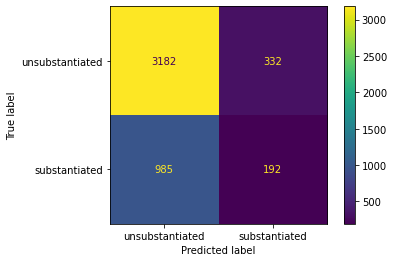

In [607]:
plot_confusion_matrix(model_boost,
                      XT_test, #use validation data for confusion matrix
                      y_test,
                      values_format='.0f',
                      display_labels=['unsubstantiated', 'substantiated']);

In [347]:
#hyper parameter tuning for boost model
  
   
boost_params = {
            'eta': np.arange(0,1,.2),
            'max_depth': range(2,25,2),
            'n_estimators':range(5,85,2),
            'max_delta_step': range(1,10,1)

}

tune_boost = GridSearchCV(model_boost,
                           param_grid =boost_params,
                           scoring='accuracy',
                           cv=5,
                           n_jobs=-1,
                           verbose=1)

In [480]:
tune_boost.fit(XT_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


KeyboardInterrupt: 

In [349]:
tune_boost.best_params_

{'eta': 0.0}

In [608]:
#tuned boosted model
model_boost_tuned = XGBClassifier(booster='dart',
                            n_estimators= 80,
                            num_parallel_tree= 1,
                            max_delta_step=3,
                            eval_set= eval_set,
                            max_samples=.02,
                            max_depth = 13,
                            random_state= 42,
                            
                            n_jobs=-1)

In [609]:
#reinitialize the test and training data
XT_train = ct.fit_transform(X_train)
XT_val = ct_test.fit_transform(X_test)

In [610]:
model_boost_tuned.fit(XT_train, y_train)

[16:16:00] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { eval_set, max_samples } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1,
              eval_set=[(array([[  1.,   1.,   1., ...,  26.,  73.,   7.],
       [  2.,   1.,   1., ...,  24., 113.,  21.],
       [  2.,   1.,   2., ...,  44.,  19.,   9.],
       ...,
       [  2.,   1.,   1., ...,  18.,  32.,   4.],
       [  2.,   2.,   1., ...,  22., 114.,  16.],
       [  1.,   1.,   1., ...,  31.,  79.,   6.]]),
                         year_received
2019    False
2005    False
2009    False
2003    False
2013     True
        ...  
2008...
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=3, max_depth=13, max_samples=0.02,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=80, n_jobs=-1, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, sub

In [625]:
print('boosted model training score:', model_boost_tuned.score(XT_train, y_train))
print('boosted model test score:', model_boost_tuned.score(XT_test, y_test))

boosted model training score: 0.9929112034964289
boosted model test score: 0.7120017053933063


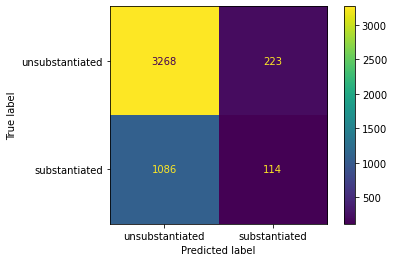

In [558]:
plot_confusion_matrix(model_boost_tuned,
                      XT_test, #use validation data for confusion matrix
                      y_test,
                      values_format='.0f',
                      display_labels=['unsubstantiated', 'substantiated']);

In [619]:
#initialize permutaion importance and set it on model
perm_imp = permutation_importance(model_boost_tuned,
                                  XT_test,
                                  y_test,
                                  n_jobs=11,
                                  random_state=42)

In [620]:
data = {'importances_mean' : perm_imp['importances_mean'],
        'importances_std' : perm_imp['importances_std']}

importance_df = pd.DataFrame(data, index=X_test.columns)
importance_df.sort_values(by='importances_mean', inplace=True)

Text(0.5, 1.0, 'Permutation importance for model_boost_Tuned')

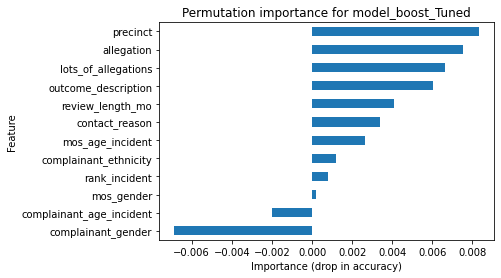

In [621]:
#permutation importantance in XGBoost model

importance_df['importances_mean'].plot(kind='barh')
plt.xlabel('Importance (drop in accuracy)')
plt.ylabel('Feature')
plt.title('Permutation importance for model_boost_Tuned')

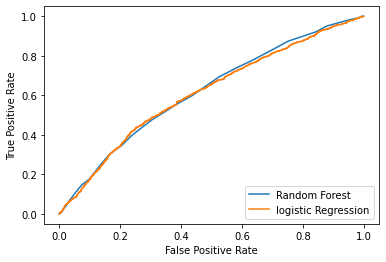

In [623]:
#ROC curve for random forest and logistic regression

rf =  plot_roc_curve(tuned_model_rf, XT_test, y_test, label='Random Forest')
logistic = plot_roc_curve(lr_model, XT_test, y_test, ax=rf.ax_, label='logistic Regression')
plt.legend;